# Estimating and Modeling Receptive Field Maps

## 1 Preparation

Import the modules required for this notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit
import scipy.ndimage as ndi
import seaborn as sns

Download the data required for this notebook

In [2]:
import requests

url = "https://uni-bonn.sciebo.de/s/Smx83PH5Wgf7mDe"
fname = "gabor_spikes.parquet"
response = requests.get(f"{url}/download")
print("Downloading Data ...")
with open(fname, "wb") as file:
    file.write(response.content)
print("Done!")

Define the functions required for this notebook

In [3]:
class utils:
    @staticmethod
    def gaussian_2d(xy, b, x0, y0, s_x, s_y, a):
        x, y = xy
        gaussian = (
            b * np.exp(-((x - x0) ** 2 / (2 * s_x**2) + (y - y0) ** 2 / (2 * s_y**2)))
            + a
        )
        return gaussian

    @staticmethod
    def fit_gaussian_2d(rf):

        rf[:] = ndi.gaussian_filter(rf, sigma=1)
        x = rf.columns.astype(float).values
        y = rf.index.astype(float).values
        Z = rf.values
        X, Y = np.meshgrid(x, y)
        xy = np.vstack((X.ravel(), Y.ravel()))  # shape = (2, N)
        z = Z.ravel()
        # initia guesses
        max_w = 80
        lb = [0, x.min(), y.min(), 1e-2, 1e-2, -np.inf]
        ub = [np.inf, x.max(), y.max(), max_w, max_w, np.inf]

        # simple initial guess:
        if z.sum() <= 0:  # no signal (all zeros or negative)
            idx = np.argmax(z)
            yi, xi = np.unravel_index(idx, rf.shape)
            x0 = X[yi, xi]  # peak in x
            y0 = Y[yi, xi]  # peak in y
        else:
            x0 = np.sum(X * rf.values) / z.sum()  # center-of-mass in x
            y0 = np.sum(Y * rf.values) / z.sum()  # center-of-mass in y
        b0 = z.max() - z.min()  # amplitude
        a0 = z.min()  # offset (baseline)
        s0 = max((x.ptp(), y.ptp())) / 4.0  # rough width
        p0 = [b0, x0, y0, s0, s0, a0]

        popt, pcov = curve_fit(utils.gaussian_2d, xy, z, p0=p0, bounds=(lb, ub))
        return popt, xy

    @staticmethod
    def r_squared(y, y_fit):
        y = y.to_numpy().flatten()
        y_fit = y_fit.flatten()
        ss_res = np.sum((y - y_fit) ** 2)
        ss_tot = np.sum((y - np.mean(y_fit)) ** 2)
        r2 = 1 - (ss_res / ss_tot)
        if r2 < 0:
            r2 = 0
        return r2

    @staticmethod
    def get_rf_outline(popt, sigma=1):
        x0, y0, sigma_x, sigma_y = popt[1:5]
        theta = np.linspace(0, 2 * np.pi, 100)
        x = x0 + sigma * sigma_x * np.cos(theta)
        y = y0 + sigma * sigma_y * np.sin(theta)
        return x, y

## 2 Computing and Visualizing Receptive Field Maps

Many sensory systems, such as vision, somatosensation and audition
exhibit perceptual maps where neurons respond to specific regions of the
perceptual space - in vision this is literally the patch of the visual
field; in audition it’s a band of frequencies; in somatosensation it’s a
patch of skin. The fraction of perceptual space to which a neuron
responds is the neuron’s receptive field. One can map a neuron’s
receptive field by recordings its responses while sampling the
perceptual space. In this section, we are going to explore how to
compute receptive field maps for visual neurons. We are going to use
recordings from a mouse that was presented with gabor patches - simple
visual gratings, presented at a specific location with a specific
orientation. By counting the number of spikes elicited by a Gabor patch
at every position, we can estimate a receptive field map that reveals
the patch of the visual field the neurons responds to.

| Code | Description |
|------------------------------------|------------------------------------|
| `df = pdf.read_parquet(mydata.parquet)` | Read the file `"mydata.parquet"` into a data frame `df` |
| `df["col1"].unique()` | Get the `.unique()` values in column `"col1"` |
| `df.groupby(["col1", "col2"]).size().unstack()` | Group `df` by `"col1"` and `"col2"`, get the number of rows for each grouping and pivot the table so that the inner most index becomes a new set of columns |
| `sns.heatmap(df)` | Plot the data frame `df` as a heatmap |
| `sns.heatmap(df, cmap="jet")` | Plot a heatmap of `df` using the `"jet"` colormap |
| `ndi.zoom(x, zoom=5)` | Upscale the image `x` by a factor of `5` |
| `ndi.gaussian_filter(x, sigma=1)` | Apply a `gaussian_filter` with standard deviation `sigma=1` to the image `x` |

------------------------------------------------------------------------

<span class="theorem-title">**Exercise 1**</span> Load the data stored
in `"gabor_spikes.parquet"` into a pandas data frame.

​

<span class="theorem-title">**Exercise 2**</span> What are the different
values for `"x_position"`, `"y_position"` and `"orientation"` in the
data?

​

<span class="theorem-title">**Example 1**</span> Compute the average
receptive field map `rf` for the whole recording by grouping the data by
`"x_position"` and `"y_position"`, getting the `.size()` an
`.unstack()`ing the result to get a 2D grid.

In [8]:
rf = df.groupby(["y_position", "x_position"]).size().unstack()
rf

<span class="theorem-title">**Exercise 3**</span> Plot the receptive
field `rf` with `sns.heatmap`.

​

<span class="theorem-title">**Exercise 4**</span> Plot the receptive
field map for unit `951028431`.

​

<span class="theorem-title">**Exercise 5**</span> Plot the receptive
field map for unit `951027930`.

​

<span class="theorem-title">**Example 2**</span> Use `ndi.zoom` to
upscale the receptive field map by a factor of `zoom=5` and then use
`ndi.gaussian_filter` to smooth the image.

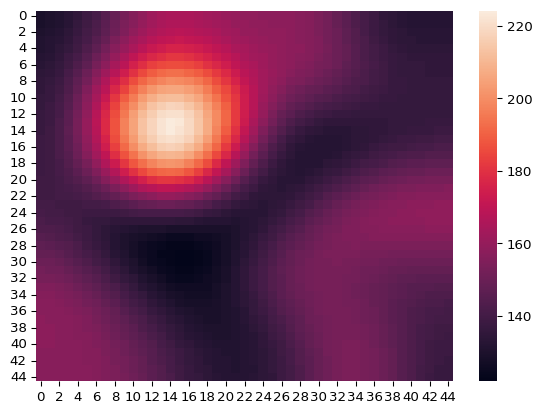

In [15]:
rf_interp = ndi.gaussian_filter(ndi.zoom(rf, zoom=5), sigma=5)
sns.heatmap(rf_interp)

<span class="theorem-title">**Exercise 6**</span> Re-create the plot
above with `sigma=5`.

​

<span class="theorem-title">**Exercise 7**</span> Re-create the plot
above with `zoom=10` and `sigma=10`. What are the advantages and
downsides of applying upscaling and smoothing?

​

<span class="theorem-title">**Exercise 8**</span> Re-create the heatmap
plot of the interpolated image but add the `cmap` argument. Try the
values `"viridis"`, `"Greys"` and `"jet"`. Which of these is a good
colormap choice for a receptive field plot?

​

## 3 Visualizing Receptive Fields Across Brain Areas

Now we know how to compute and visualize receptive field maps. However,
modern multi-electrode recordings contain lots of neurons such that
plotting and inspecting them individually is not feasible. Fortunately,
seaborn provides the `FacetGrid` class for generating multi-plot grids
which allows us to quickly visualize and compare large numbers of
neurons. When instantiating a `FacetGrid`, we provide a data frame and
the categories that make up th rows and columns of our plot. We then map
a function to the data frame that performs some plotting operation and
seaborn will automatically determine the correct location of the plot.

| Code | Description |
|------------------------------------|------------------------------------|
| `def fun(data, *args, **kwargs)` | Define a function `fun` that takes an argument `data` as well as an arbitrary number of positional `*args` and keyword arguments `**kwargs` |
| `g = sns.FacetGrid(data=df, col="col1")` | Create a multi-plot grid for the data frame `df` with one column for each unique value in `"col1"` |
| `g = sns.FacetGrid(data=df, col="col1")` | Create a multi-plot grid with one column for each unique value in `"col1"` and start a new row every `3` plots |
| `g = sns.FacetGrid(data=df, col="col1", row="col2")` | Create a multi-plot grid with one column for each unique value in `"col1"` and one row for each value in `"col2"` |
| `g.map_dataframe(fun)` | Map the function `fun` to the data frame associated with the multi-plot grid `g` |
| `units = df[df.col1 == "a"]` | Get all rows in `df` where the value `"col1"` is `"a"` |
| `units = df[df.col1.isin(x)]` | Get all rows in `df` where the value of `"col1"` is in the list `x` |

------------------------------------------------------------------------

<span class="theorem-title">**Example 3**</span> Create a multi-plot
grid where each column represents one `"brain_area"`, then define a
function `fun` that takes in a data frame `data`, computes the receptive
field map and plots it and map that function to the grid to plot the
average rf for every brain area.

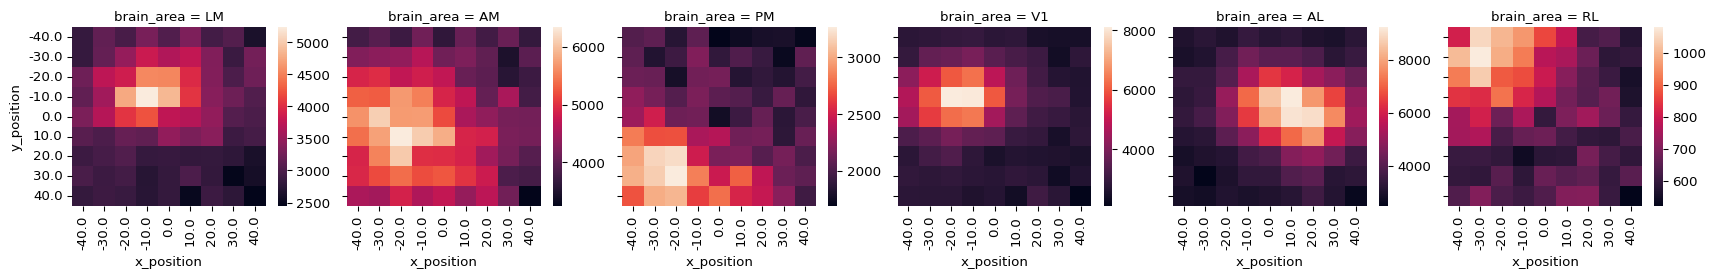

In [22]:
def fun(data, *args, **kwargs):
    rf = data.groupby(["y_position", "x_position"]).size().unstack()
    sns.heatmap(rf)


g = sns.FacetGrid(data=df, col="brain_area")
g.map_dataframe(fun)

<span class="theorem-title">**Exercise 9**</span> Create a multi-plot
grid where each `row` represents one `"brain_area"` and each column
represents one `"orientation"`. Then, map the function `fun` to the grid
to draw the average receptive field map for every brain area and every
stimulus orientation.

​

<span class="theorem-title">**Exercise 10**</span> The code below
selects the first `9` unique `units` in the primary visual cortex
`"V1"`. Plot their receptive field maps with `col="unit_id"` and set
`col_wrap=3` to create a new row every `3` plots. How many units show a
clearly visible receptive field?

In [25]:
units = df[df.brain_area == "V1"].unit_id.unique()[:9]
units = df[df.unit_id.isin(units)]
units

77249 rows × 6 columns

​

<span class="theorem-title">**Exercise 11**</span> Plot the first `9`
unique `unit` in the anterolateral area `"AL"`. How do these receptive
field maps look compared to the ones from `"V1"`?

​

<span class="theorem-title">**Exercise 12**</span> The code below
samples `5` random `units` from every `"brain_area"` and assigns a
`"unit_rank"` to each unit per areas. Plot the receptive field maps of
the `units` with a `row` for every `"unit_rank"` and a `col` for every
`"brain_area"` (HINT: since the sampling is random, you’ll get a
different plot everytime you run the cell below).

In [30]:
units = df[["brain_area", "unit_id"]].drop_duplicates().groupby("brain_area").sample(5)
units["unit_rank"] = units.groupby("brain_area").cumcount()
del units["brain_area"]
units = df.merge(units, on="unit_id")
units

109321 rows × 7 columns

​

<span class="theorem-title">**Exercise 13**</span> Modify the plotting
fuction `fun` to use `cmap="Greys"` and re-create the plot with the
average receptive field map per area from
<a href="#exm-rfs" class="quarto-xref">Example 3</a>.

​

<span class="theorem-title">**Exercise 14**</span> (BONUS): modify the
function `fun` to upscale and smooth the receptive field maps as shown
in <a href="#exm-smooth" class="quarto-xref">Example 2</a>. Then,
re-create the plot with the average receptive field map per area.

​

## 4 Fitting Gaussian Models to Receptive Field Maps

In the previous section we saw that some neurons have a receptive field
with a sharply localized peak while others are more spread out.
Visualizing receptive field maps is a great way for getting an idea
about the trends in our data but a systematic analysis and comparison of
receptive fields requires us to parameterize their properties. In this
section, we are going to learn how to fit a model to the receptive field
map and use this model to determine the outline of the receptive field.
For this we are going to use a 2-dimensional Gaussian of the form:

$$
b \exp\left(-\left[\frac{(x - \mu_x)^2}{2\sigma_x^2} + \frac{(y - \mu_y)^2}{2\sigma_y^2}\right]\right)
$$

Which is a simple model that has a very clear interpretation because the
standard deviation parameters $\sigma_x$ and $\sigma_y$ represent the
width and height of the receptive field and the receptive field area is
given by $\pi \sigma_x \sigma_y$.

| Code | Description |
|------------------------------------|------------------------------------|
| `popt, xy = utils.fit_gaussian_2d(rf)` | Fit a 2D Gaussian to the receptive field `rf` and return the optimal parameters `popt` and the grid of coordinates `xy` |
| `rf_fit = utils.gaussian_2d(xy, *popt).reshape(rf.shape)` | Generate `rf_fit` as a 2D Gaussian with the coordinate grid `xy` and the optimized parameters `*popt` and `.reshape()` it to the shape of `rf` |
| `utils.r_squared(rf, rf_fit)` | Compute the coefficient of determination R^2 for `rf` and `rf_fit` |
| `sigma_x, sigma_y = popt[3:5]` | Get the standard deviation in x and y, `sigma_x` and `sigma_y`, from the optimal parameters od the 2D Gaussian |
| `x, y = utils.get_rf_outline(popt)` | Get the `x` and `y` coordinates that form the outline of the Gaussian fot of the receptive field |
| `plt.plot(x, y, color="black")` | Plot the points with coordinates `x` and `y` and connect them with `"black"` lines |
| `plt.subplot(1, 2, 1)` | Create the first subplot in a 1 by 2 grid |
| `plt.subplot(1, 2, 2)` | Create the seconds subplot in a 1 by 2 grid |
| `plt.imshow(rf, extent=[-45, 45, -45, 45], origin="lower")` | Plot the receptive field `rf` as an image that extends from `-45` to `45` in x and y and where the first row of `rf` is drawn at the `"lower"` end of the plot |

------------------------------------------------------------------------

<span class="theorem-title">**Example 4**</span> Compute the receptive
field map for unit `951028431` and fit a 2-D Gaussian to it. Then, use
the optimized parameters `popt` and the grid of coordinates `xy` to
generate the fitted receptive field map `rf_fit` and compute the
coefficient of determination using `utils.r_squared()`.

In [37]:
unit = 951028431
rf = df[df.unit_id == unit].groupby(["y_position", "x_position"]).size().unstack()
popt, xy = utils.fit_gaussian_2d(rf)
rf_fit = utils.gaussian_2d(xy, *popt).reshape(rf.shape)
utils.r_squared(rf, rf_fit)

0.9900711534689108

<span class="theorem-title">**Example 5**</span> Plot the estimated
receptive field map `rf` next to the map predicted from the Gaussian
model `rf_fit`.

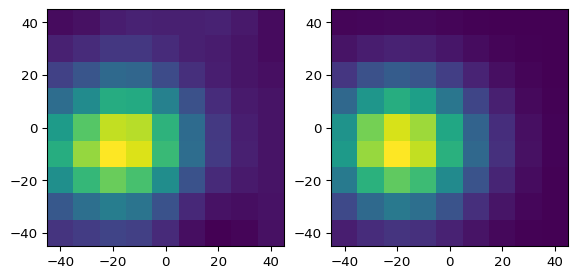

In [38]:
plt.subplot(1, 2, 1)
plt.imshow(rf, extent=[-45, 45, -45, 45], origin="lower")
plt.subplot(1, 2, 2)
plt.imshow(rf_fit, extent=[-45, 45, -45, 45], origin="lower")

<span class="theorem-title">**Exercise 15**</span> Compute the receptive
field map for unit `951035530` and fit a 2-D Gaussian to it. Then, use
the optimized parameters `popt` and the grid of coordinates `xy` to
generate the fitted receptive field map `rf_fit` and compute the
coefficient of determination using `utils.r_squared()`.

​

<span class="theorem-title">**Exercise 16**</span> Plot the estimated
receptive field map `rf` next to the map predicted from the Gaussian
model `rf_fit`.

​

<span class="theorem-title">**Exercise 17**</span> Compute the receptive
field map for unit `951031429`, fit a 2-D Gaussian and compute
`utils.r_squared()`. What does the value of $R^2$ tell you about how
well the model fits the data?

​

<span class="theorem-title">**Exercise 18**</span> Plot the estimated
receptive field map `rf` next to the map predicted from the Gaussian
model `rf_fit`. Do you think a 2D Gaussian is a good description of this
data?

​

<span class="theorem-title">**Exercise 19**</span> Compute the receptive
field map for unit `951031429`, fit a 2-D Gaussian and compute
`utils.r_squared()`. Would you consider the model a good fit based on th
evalue of $R^2$?

​

<span class="theorem-title">**Exercise 20**</span> Plot the estimated
receptive field map `rf` next to the map predicted from the Gaussian
model `rf_fit`. Do you think a 2D Gaussian is a good description of this
data?

​

<span class="theorem-title">**Example 6**</span> Fit a model to the
receptive field map of unit `951028431` and get width and height as the
standard deviation of the 2D Gaussian in x (`sigma_x`) and y
(`sigma_y`). Print the width, height and area of the receptive field.

In [51]:
unit = 951028431
rf = df[df.unit_id == unit].groupby(["y_position", "x_position"]).size().unstack()
popt, xy = utils.fit_gaussian_2d(rf)
sigma_x, sigma_y = popt[3:5]

print("RF width: ", np.abs(sigma_x), "degree")
print("RF height: ", np.abs(sigma_y), "degree")
print("RF area: ", np.pi * np.abs(sigma_x) * np.abs(sigma_y), "degree^2")

RF width:  19.425092453344845 degree
RF height:  17.008349896630815 degree
RF area:  1037.9469302129273 degree^2

<span class="theorem-title">**Example 7**</span> Get the x, y
coordinates that for the outline of the receptive field model at
`sigma=1` and plot it together with the receptive field map.

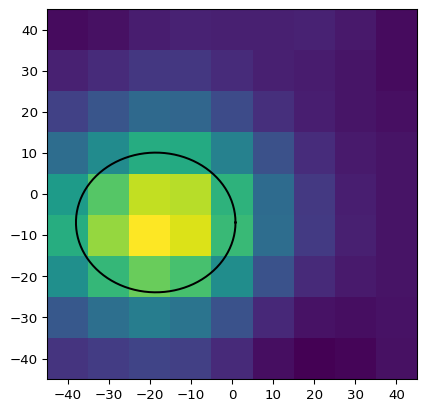

In [52]:
x, y = utils.get_rf_outline(popt)
plt.imshow(rf, extent=[-45, 45, -45, 45], origin="lower")
plt.plot(x, y, color="black")

<span class="theorem-title">**Exercise 21**</span> Fit a model to the
receptive field map of unit `951035530` and get width and height as the
standard deviation of the 2D Gaussian in x (`sigma_x`) and y
(`sigma_y`). Print the width, height and area of the receptive field.

​

<span class="theorem-title">**Exercise 22**</span> Get the x, y
coordinates that for the outline of the receptive field model at
`sigma=1.5` and plot it together with the receptive field map.

​

<span class="theorem-title">**Exercise 23**</span> Fit a model to the
receptive field map of unit `951027930` and get width and height as the
standard deviation of the 2D Gaussian in x (`sigma_x`) and y
(`sigma_y`). Print the width,V height and area of the receptive field.

​

<span class="theorem-title">**Exercise 24**</span> Get the x, y
coordinates that for the outline of the receptive field model at
`sigma=2` (encompasses about 95% of the model’s probability mass) and
plot it together with the receptive field map.

​

## 5 Comparing Receptive Fields Across Visual Areas

Now, we can use the 2D Gaussian to model every unit in our recording and
use the estimated parameters to compare the receptive field fits and
sizes across the different visual areas. We know that, as you ascend the
hierarchy of the visual system, receptive fields do not only get larger
but also become more complex. Thus, our simple 2D Gaussian may be a
worse fit for the receptive fields in higher visual areas. To keep
things simple, we can focus our analysis on those neurons that are well
described by the Gaussian model (as indicated by a high value of $R^2$).

| Code | Description |
|------------------------------------|------------------------------------|
| `df.groupby(["col1", "col2"]).size().unstack(fill_values=0)` | Group `df` by `"col1"` and `"col2"`, get the number of rows for each grouping and pivot the table so that the inner most index becomes a new set of columns. Fill the cells without any observations with the value `0`. |
| `sns.histplot(df, x="col1")` | Create a histogram of the values in `"col1"` |
| `sns.kdeplot(df, x="col1", hue="col2", common_norm=False)` | Plot the distribution of the values in `"col1"` for each unique value in `"col2"` and normalize the distribution separately |
| `sns.barplot(df, x="col1", y="col2")` | Create a barplot with `"col1"` on the x-axis and `"col2"` on the y-axis |
| `df["col3"] = df.col1 * df.col2` | Create a new column `"col3"` that is the product of the values in `"col1"` and `"col2"` |
| `df[df.col1>x]` | Get all rows of `df` where the value of `"col1"` is greater than `x` |
| `np.pi` | Get the value of $\pi$ |
| `np.abs(x)` | Get the absolute values of `x` |

The cell below defines the function `fit_one_unit()` that combines the
analysis steps from the previous sections: it computes the receptive
field map, fits a 2D gaussian and returns `r_squared` as well as
`sigma_x` and `sigma_y`. This function is applied to every unit to
obtain a table that contains the statistical properties of every
neuron’s receptive field. Run the code to generate the data frame
`rf_stats` with the statistial properties of every neuron’s receptive
field.

In [61]:
def fit_one_unit(df):
    rf = df.groupby(["y_position", "x_position"]).size().unstack(fill_value=0)
    popt, xy = utils.fit_gaussian_2d(rf)
    rf_fit = utils.gaussian_2d(xy, *popt).reshape(rf.shape)
    r_squared = utils.r_squared(rf, rf_fit)
    sigma_x, sigma_y = popt[3:5]
    return pd.Series(
        [r_squared, sigma_x, sigma_y], index=["r_squared", "sigma_x", "sigma_y"]
    )


rf_stats = (
    df.groupby(["brain_area", "unit_id"])
    .apply(fit_one_unit, include_groups=False)
    .reset_index()
)
rf_stats

385 rows × 5 columns

<span class="theorem-title">**Exercise 25**</span> Use `sns.histplot` to
plot the distribution of `"r_squared"` values across all receptive field
models.

​

<span class="theorem-title">**Exercise 26**</span> Use `sns.kdeplot` to
plot the distribution of `"r_squared"` with a `hue` for `"brain_area"`
and without applying a `common_norm`. For which brain area is the 2D
Gaussian model of the neurons’ receptive fields most accurate?

​

<span class="theorem-title">**Exercise 27**</span> Calculate the
receptive field areas as `np.pi * sigma_x * sigma_y` and assign them to
a new column `"rf_area"`. Why do we have to take the absolute values of
`sigma_x` and `sigma_y` ?

​

<span class="theorem-title">**Exercise 28**</span> Use `sns.barplot`
with `"brain_area"` on the `x` axis and `"rf_area"` on the `y` axis. In
which area are the receptive fields the smallest?

​

<span class="theorem-title">**Exercise 29**</span> Recreate the barplot
but only include the receptive fields where the value of $R^2$ is above
`0.8`. How does this affect the outcome?

​